In [1]:
import os
import sys
from tqdm import tqdm
import time
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.utils.labels_mapping import RelabelByModality
from src.utils.loss import HybridDiceCLDiceLoss
from src.features.utils import BalancedCTMRSampler

import torch
import monai
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from typing import Dict

from monai.transforms import (
    Compose,
    MapTransform,
    LoadImaged,
    EnsureChannelFirstd,
    RandCropByPosNegLabeld,
    RandAffined,
    RandAdjustContrastd,
    RandGaussianNoised,
    RandScaleIntensityd,
    AsDiscrete
)
from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
from monai.inferers import sliding_window_inference

from monai.networks.nets import UNet

In [2]:
# Load data
train_data = pd.read_csv('../data/processed/train_split.csv')
train_data = train_data.drop(columns=['file_name']).rename(columns={'image_path': 'image', 'label_path': 'label'})
train_data['image'] = train_data['image'].apply(lambda x: os.path.join('..', x))
train_data['label'] = train_data['label'].apply(lambda x: os.path.join('..', x))
train_dict = train_data.to_dict('records') # list of dict (one per image) like [{'image':..., 'label':..., 'modality':...}, ...]

test_data = pd.read_csv('../data/processed/test_split.csv')
test_data = test_data.drop(columns=['file_name']).rename(columns={'image_path': 'image', 'label_path': 'label'})
test_data['image'] = test_data['image'].apply(lambda x: os.path.join('..', x))
test_data['label'] = test_data['label'].apply(lambda x: os.path.join('..', x))
test_dict = test_data.to_dict('records') # list of dict (one per image) like [{'image':..., 'label':..., 'modality':...}, ...]

# Augmentations implementation

In [3]:
class AugmentByModality(MapTransform):
    """Apply different pipelines of augmentations based on image modality."""
    def __init__(self, keys: list, modality_key: str = "modality", pipes:Dict[str, Compose] = None):
        super().__init__(keys)
        self.modality_key = modality_key
        self.pipes = pipes if pipes is not None else {}

    def __call__(self, data: dict) -> dict:
        d = dict(data)

        modality = d.get(self.modality_key, None)
        pipe = self.pipes.get(modality, None)

        if pipe is not None:
            d = pipe(d)
            
        return d

In [4]:
# Define transforms specific to each modality
cta_transforms = Compose([
    RandAdjustContrastd(keys=['image'], prob=1, gamma=(0.95, 1.10))
])

mra_transforms = Compose([
    RandAdjustContrastd(keys=['image'], prob=1, gamma=(0.8, 1.25)),
    RandScaleIntensityd(keys=['image'], factors=0.1, prob=1)
])

In [5]:
# Define overall training and testing augmentations
train_augmentations = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    RelabelByModality(keys=['label']),
    RandCropByPosNegLabeld(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        pos=1,
        neg=1,
        num_samples=4,
        image_key="image",
        image_threshold=0),
    RandAffined(
        keys=['image', 'label'],
        mode=['bilinear', 'nearest'],
        prob=1,
        rotate_range=(0, 0, np.pi/20),
        scale_range=(0.1, 0.1, 0.1),
        translate_range=(5, 5, 5),
        padding_mode='zeros'
    ),
    RandGaussianNoised(
        keys=['image'],
        prob=1,
        mean=0.0,
        std=0.01
    ),
    AugmentByModality(
        keys=['image'],
        pipes={
            'ct': cta_transforms,
            'mr': mra_transforms
        }
    )
])

test_augmentations = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    RelabelByModality(keys=['label'])
])

In [6]:
train_ds = Dataset(data=train_dict, transform=train_augmentations)
train_loader = DataLoader(train_ds, batch_size=1, num_workers=4, sampler=BalancedCTMRSampler(train_ds))

test_ds = Dataset(data=test_dict, transform=test_augmentations)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4)

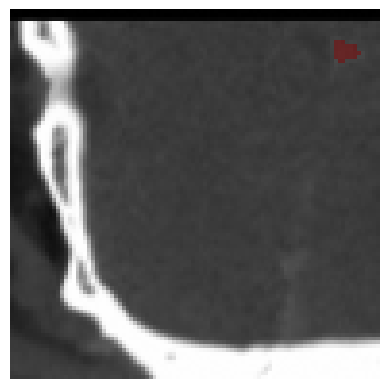

In [7]:
# Test train data loading
batch = next(iter(train_loader))

img_slice = batch['image'][0, :, :, batch['image'].shape[-2]//2, :]
label_slice = batch['label'][0, :, :, batch['label'].shape[-2]//2, :]

# superpose image and label for visualization
img = monai.visualize.blend_images(img_slice, label_slice, alpha=0.5, cmap="jet").permute(1, 2, 0)

plt.imshow(img)
plt.axis('off')
plt.show()

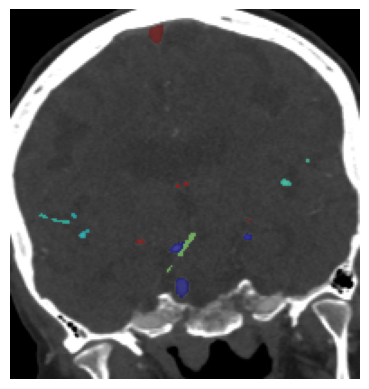

In [8]:
# Test test data loading
batch = next(iter(test_loader))

img_slice = batch['image'][0, :, :, batch['image'].shape[-2]//2, :]
label_slice = batch['label'][0, :, :, batch['label'].shape[-2]//2, :]

# superpose image and label for visualization
img = torch.rot90(monai.visualize.blend_images(img_slice, label_slice, alpha=0.5, cmap="jet"), k=1, dims=(1, 2)).permute(1, 2, 0)

plt.imshow(img)
plt.axis('off')
plt.show()

# Create Model, Loss, Optimizer

In [9]:
def infer_volume(model, inputs, vol_size=(96, 96, 96), sw_patch_size=4, overlap=0.25):
    """Infer a 3D image volume using sliding window inference."""
    model.eval()
    with torch.no_grad():
        return sliding_window_inference(
            inputs = inputs,                    # e.g. a 3D image volume
            roi_size = vol_size,                # size of the sliding window
            sw_batch_size = sw_patch_size,      # number of sliding windows to process in parallel
            predictor = model,                  # the model to run
            overlap = overlap                   # amount of overlap between sliding windows
        )

In [10]:
# calculate weights for HybridDiceCLDiceLoss with train data
counter = [0 for i in range(49)] # 0-48 labels
remap = RelabelByModality('label')
for p, modality in zip(train_data['label'], train_data['modality']):
    label_nii = nib.load(p)
    label_data = label_nii.get_fdata()
    label_data = remap({'label': label_data, 'modality': modality})['label']
    unique, counts = np.unique(label_data, return_counts=True)
    for u, c in zip(unique, counts):
        counter[int(u)] += c

weights = torch.tensor(counter)
weights = 1 / (weights + 1e-6) # inverse frequency
weights = weights / weights.sum() # normalize to sum to 1
weights = weights * 49  # scale to have mean of 1

In [11]:
device = torch.device("cuda")

In [12]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=49,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    bias=False
)

model = model.to(device)

loss_function = HybridDiceCLDiceLoss(iter_=7, class_weights=weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# metrics
dice_metric = monai.metrics.DiceMetric(include_background=True, reduction="mean", num_classes=49)


In [ ]:
max_epochs = 100
val_interval = 1 
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=49)])
post_label = Compose([AsDiscrete(to_onehot=49)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    ####################################
    ############# Training #############
    ####################################

    model.train() # set model to training mode
    train_loss = 0 # initialize epoch loss
    progress_bar = tqdm(train_loader, 
                        bar_format='[{elapsed}<{remaining}] step: {n_fmt}/{total_fmt} | {l_bar}{bar} {rate_fmt}{postfix}', 
                        colour='yellow') # progress bar for training
    for step, batch_data in enumerate(progress_bar, start=1): # for each batch
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad() # reset gradients
        outputs = model(inputs) # calculate outputs
        loss = loss_function(outputs, labels) # compute loss
        loss.backward() # propagate loss
        optimizer.step() # update weights
        train_loss += loss.item() # accumulate step loss
        train_loss_average = train_loss / step # calculate actual average loss (for display purposes)
        progress_bar.set_postfix({"Epoch training loss": f"{train_loss_average:.4f}"})
    train_loss /= len(train_loader) # average loss for the epoch
    epoch_loss_values.append(train_loss) # record epoch loss

    ######################################
    ############# Validation #############
    ######################################

    val_loss = None # initialize validation loss
    if (epoch + 1) % val_interval == 0:
        model.eval() # set model to evaluation mode
        with torch.no_grad():
            val_loss = 0 # initialize epoch loss
            for val_data in test_loader:
                inputs, labels = val_data["image"].to(device), val_data["label"].to(device)
                outputs = infer_volume(model, inputs, vol_size=(96, 96, 96), sw_patch_size=4, overlap=0.1) # infer the image volume
                val_loss += loss_function(outputs, labels).item() # accumulate loss value for each batch of validation
                outputs = [post_pred(i) for i in decollate_batch(outputs)]
                labels = [post_label(i) for i in decollate_batch(labels)]
                dice_metric(outputs, labels) # calculate dice metric for the current image volume
            val_loss /= len(test_loader) # average loss for validation dataset
            metric = dice_metric.aggregate().item() # aggregate the dice metric for the whole validation dataset
            dice_metric.reset() # reset the metric for the next validation round
            metric_values.append(metric) # record metric value
            if metric > best_metric: # if the current model is the best, save it
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model.pth")
                print("saved new best metric model")
            print(f"current epoch: {epoch + 1} current mean dice: {metric:.4f} best mean dice: {best_metric:.4f} at epoch {best_metric_epoch}")

    print(f"-----> epoch {epoch + 1} average loss: {train_loss:.4f}, average val loss: {val_loss:.4f}") if val_loss is not None else print(f"-----> epoch {epoch + 1} average loss: {train_loss:.4f}")

print("#" * 10)
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/100


[00:31<?] step: 0/36 |   0%|           ?it/s, Epoch training loss=5.4766


------------- New validation case -------------
Calculating output ...


/home/antoine/MachineLearning/projects/TopBrain2025/.venv/lib/python3.11/site-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/home/antoine/MachineLearning/projects/TopBrain2025/.venv/lib/python3.11/site-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result 

Calculating loss ...
decollating outputs ...
decollating labels ...
calculating dice metric ...
------------- New validation case -------------
Calculating output ...
Calculating loss ...
decollating outputs ...
decollating labels ...
calculating dice metric ...
------------- New validation case -------------
Calculating output ...
Calculating loss ...
decollating outputs ...
decollating labels ...
calculating dice metric ...
------------- New validation case -------------
Calculating output ...
Calculating loss ...
decollating outputs ...
decollating labels ...
calculating dice metric ...
------------- New validation case -------------
Calculating output ...
Calculating loss ...
decollating outputs ...
decollating labels ...
calculating dice metric ...
------------- New validation case -------------
Calculating output ...
Calculating loss ...
decollating outputs ...
decollating labels ...
calculating dice metric ...
------------- New validation case -------------
Calculating output ..

KeyboardInterrupt: 